# Temporarily disable GPU for building on local machine

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Introduction

This example shows how to train a neural network to recognize text in images.  We use Keras's functional API to implement a model based on the CRNN architecture. We also create both a custom loss function to adapt the CTC loss provided by `tensorflow.keras.backend`, as well as a custom metric to adapt `tf.edit_distance`.

To demonstrate this setup, we build a training dataset by generating synthetic images from a source list of words. To implement the dataset, we subclass `tensorflow.keras.utils.Sequence`. It provides an `on_epoch_end` callback, which we use for curriculum learning by gradually ramping up the difficulty of the dataset during training.

## Setup

One external package is required for this example.
* `cairocffi` provides Python bindings for `cairo`, a 2D vector graphics library written in the C programming language. We use this package to generate synthetic images of text.

If you've opened this example in Google Colab, you can install the package like this:

In [ ]:
!pip install cairocffi

Then, import the required Tensorflow dependencies.

In [ ]:
# TensorFlow packages
from tensorflow.keras import layers, losses, models, optimizers, utils
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
import tensorflow as tf

## Preparing a synthetic dataset

We train our neural network on a dataset made of synthetic images. The synthetic images are generated on the fly from a list of source text sequences. The images appear as black printed text on a white background, with image processing to add realistic noise.

> _**Note:** Other text-image datasets can be found in existing OCR research literature. These datasets are often designed for more challenging OCR applications, such as scene text recognition with non-horizontal text. If you plan to adapt this tutorial for your own work, consider using one of the following datasets: [MJSynth (MJ)](http://www.robots.ox.ac.uk/~vgg/data/text/), [SynthText (ST)](http://www.robots.ox.ac.uk/~vgg/data/scenetext/), [IIIT](http://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K.html), [SVT](http://www.iapr-tc11.org/mediawiki/index.php/The_Street_View_Text_Dataset), [IC03](http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2003_Robust_Reading_Competitions), [IC13](http://rrc.cvc.uab.es/?ch=2), [IC15](http://rrc.cvc.uab.es/?ch=4), [SVTP](http://openaccess.thecvf.com/content_iccv_2013/papers/Phan_Recognizing_Text_with_2013_ICCV_paper.pdf), and/or [CUTE](http://cs-chan.com/downloads_CUTE80_dataset.html)._



### Downloading the source word lists

First, let's download and uncompress an archive containing two text files.

In [ ]:
from pathlib import Path

tgz_path = Path(
    utils.get_file('wordlists.tgz',
                   origin='http://www.mythic-ai.com/datasets/wordlists.tgz',
                   untar=True)
)

dataset_dir = tgz_path.parent
monogram_file = dataset_dir / "wordlist_mono_clean.txt"
bigram_file   = dataset_dir / "wordlist_bi_clean.txt"

Each file contains a different set of [**n-gram**](https://en.wikipedia.org/wiki/N-gram) data samples:
* `wordlist_mono_clean.txt` contains a list of **monograms**, or single words. These words have been pre-sorted according to their frequency in English speech.
* `wordlist_bi_clean.txt` contains a list of **bigrams**, or pairs of words.

### Loading and preprocessing words

Before using these word lists to create a dataset, we filter out any unsuitable examples as we load them into memory.

We use 2 criteria for filtering:

* `ABSOLUTE_MAX_STRING_LEN` restricts the length of allowable text sequences.
* `ALPHABET` contains every allowable character. To simplify the example, we attempt to recognize only lowercase alphabetic characters.

We then combine the monograms and bigrams into a single source list of text seqeunces, then sort them based on length.

In [ ]:
import re

ABSOLUTE_MAX_STRING_LEN = 16
ALPHABET = u'abcdefghijklmnopqrstuvwxyz '

def preprocess_words(wordlist_file, valid_characters, max_string_len=None):
    def _is_valid_str(in_str):
        search = re.compile(rf'^[{valid_characters} ]+$', re.UNICODE).search
        return bool(search(in_str))

    def _is_length_of_word_valid(word):
        return (max_string_len == -1 or
                max_string_len is None or
                len(word) <= max_string_len)

    suitable_words = []
    with wordlist_file.open() as f:
        for line in f:
            word = line.rstrip()
            if _is_valid_str(word) and _is_length_of_word_valid(word):
                suitable_words.append(word)

    return suitable_words

monograms = preprocess_words(monogram_file, ALPHABET, ABSOLUTE_MAX_STRING_LEN)
bigrams   = preprocess_words(bigram_file, ALPHABET, ABSOLUTE_MAX_STRING_LEN)
sequences = sorted(monograms + bigrams, key=len)

print(f"Wordlists contain {len(sequences)} suitable text sequences.")

Wordlists contain 152494 suitable text sequences.


### Set aside words for validation

Here, we use a slightly more involved approach (compared to simple Python list indexing) to ensure that words of varying lengths are distributed evenly between the training and validation sets.


In [ ]:
import random

VAL_SPLIT = 0.2

def trn_val_split(input_list, split_ratio):
    n = round(1 / split_ratio)
    trn_list, val_list = [], []
    for i, item in enumerate(input_list):
        if i % n == 0:
            val_list.append(item)
        else:
            trn_list.append(item)

    return trn_list, val_list

trn_sequences, val_sequences = trn_val_split(sequences, VAL_SPLIT)

### Defining functions for creating synthetic text images

We use several functions to generate images from strings of text. The functions include image transformations to introduce variations in the generated images. The image transformations are controlled using flags, which can be set during training to progressively increase the difficulty of the dataset. This is referred to as [curriculum learning](https://arxiv.org/abs/1904.03626). 

The image transformations include:
* `multi_fonts`: Start by using only the `Courier` font to generate images. Then, later in training, expand the font list and choose a font at random from the list. 
* `ud`: Start by using a fixed y-coordinate for the text within the image. Then, later in training, add a random vertical shift to the y-coordinate.
* `rotate`: Start by keeping text entirely horizontal. Then, later in training, add a slight random rotation to the text.
* `speckle`: Create large "blotches" of noise, which look more realistic than simply adding gaussian noise.

These aren't the only possible transformations, however. If you're interested in examples of other image transformations used to better synthesize real-world images, the [MJSynth](https://www.robots.ox.ac.uk/~vgg/data/text/) synthetic dataset would be a good place to start.

In [ ]:
import numpy as np
from scipy import ndimage
import cairocffi as cairo

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck

def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        # Create blank white canvas
        context.set_source_rgb(1, 1, 1)
        context.paint()

        # Select the font  
        if multi_fonts:
            fonts = ['Century Schoolbook', 'Courier', 'STIX', 
                     'URW Chancery L', 'FreeMono']
            context.select_font_face(
                np.random.choice(fonts), 
                cairo.FONT_SLANT_NORMAL,
                np.random.choice([cairo.FONT_WEIGHT_BOLD, 
                                  cairo.FONT_WEIGHT_NORMAL])
            )
        else:
            context.select_font_face('Courier',
                                     cairo.FONT_SLANT_NORMAL,
                                     cairo.FONT_WEIGHT_BOLD)
        context.set_font_size(25)

        # Determine coordinates for text within the image
        box = context.text_extents(text)
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image. Max char count is '
                           'too large for given image width.'))
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        if ud:
            top_left_y = np.random.randint(0, int(max_shift_y))
        else:
            top_left_y = h // 2

        # Use coordinates to place text in image
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
        context.set_source_rgb(0, 0, 0)
        context.show_text(text)

    # Get image from cairo surface
    buf = surface.get_data()
    a = np.frombuffer(buf, np.uint8)
    a.shape = (h, w, 4)
    a = a[:, :, 0]
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)

    if rotate:
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)

    a = speckle(a)

    return a

### Building the dataset using the `Sequence` class

To contain our data, we subclass `tf.keras.utils.Sequence` rather than using Numpy arrays or generators. `Sequence` provides a handy `on_epoch_end` callback, which allows us to progressively increase the difficulty of the dataset during training.

Within our class, we also define a `_build_word_subset` method which creates a subset of words to draw from. By operating on only a subset of the words, we can easily modify characteristics of the dataset during training, such as the dataset's size, the number of blank images the dataset contains, and the max word length for images. 

> _**Note:** If the max word length is increased, the generated text may exceed the input image dimensions. Before creating the model and dataset, make sure to set `IMG_W` to a size that accommodates for all of the word lengths you plan to train on. In this example, for a `MAX_WORD_LEN` of 4, `IMG_W` is set to `32 * MAX_WORD_LEN`, or 128. This is done to keep the training duration small, so that the workflow can be quickly demonstrated._

In [ ]:
import math
import random

class TextImageDataset(utils.Sequence):
    def __init__(self, text_sequences, batch_size, img_w, img_h, downsample_factor, 
                 subset_num=-1, max_word_len=4, blank_ratio=0, start_epoch=1):
        self.batch_size = batch_size
        self.epoch_num = start_epoch
        self.downsample_factor = downsample_factor

        # Config settings for synthetic image generation function
        self.img_w = img_w 
        self.img_h = img_h 
        self.rotate=False
        self.ud=False
        self.multi_fonts=False
        
        # Base wordlist
        random.shuffle(text_sequences)
        self.text_sequences = text_sequences

        # Config settings for creating a wordlist subset
        self.subset_num = subset_num
        self.max_word_len = max_word_len
        self.blank_ratio = blank_ratio
        self.text_subset = self._build_word_subset()

    def __len__(self):
        return math.ceil(len(self.text_subset) // self.batch_size)
        
    def __getitem__(self, index):
        # Width and height are backwards from typical Keras convention,
        # because width is the time dimension when it gets fed into the RNN
        X_batch = np.ones([self.batch_size, self.img_w, self.img_h, 1])
        y_batch = np.ones([self.batch_size, ABSOLUTE_MAX_STRING_LEN + 2])
        
        for i in range(self.batch_size):
            text = self.text_subset[index + i]
            X_batch[i, 0:self.img_w, :, 0] = (
                paint_text(text, self.img_w, self.img_h,
                           self.rotate, self.ud, self.multi_fonts)[0, :, :].T
            )
            y_batch[i] = self._text_to_labels(text)
        
        return X_batch, y_batch

    def _text_to_labels(self, text):
        # to use k.backend.ctc_batch_loss, 3 pieces of information are needed:
        #   1. y_true (text, in integer form, padded out to max string length)
        #   2. sequence length for each batch item in y_true
        #   3. sequence length for each batch item in y_pred
        if text == '':
            int_text = [len(ALPHABET)]  # Additional int val for blank token
        else:
            int_text = [ALPHABET.find(c) for c in text]
        y_true = int_text + [-1]*(ABSOLUTE_MAX_STRING_LEN - len(int_text))
        y_true_len = [len(int_text)]
        y_pred_len = [self.img_w // self.downsample_factor - 2]

        # Keras losses only accept 2 inputs (label, y_pred), so we concatenate
        label = y_pred_len + y_true_len + y_true

        return label

    def _build_word_subset(self):
        string_list = []

        for text in self.text_sequences:
            if len(string_list) == self.subset_num:
                break
            if len(text) <= self.max_word_len:
                string_list.append(text)

        # "This seems to be important for achieving translational invariance"
        for _ in range(round(len(string_list) * self.blank_ratio)):
            string_list.append('')
            
        random.shuffle(string_list)

        return string_list
        
    def on_epoch_end(self):
        # Update paint function parameters to implement curriculum learning
        self.epoch_num += 1  # Sets for the next epoch (1-based index)
        if self.epoch_num >= 3:
            self.ud=True
        if self.epoch_num >= 5:
            self.multi_fonts=True
        if self.epoch_num >= 7:
            self.rotate=True

Now, we can create our training and validation datasets using the source word lists.

In [ ]:
SUBSET_NUM = 8000   # Number of words to pull from source lists into a subset
MAX_WORD_LEN = 4    # Limit word length within subset
BLANK_RATIO = 0.2   # Add (0.2 * SUBSET_NUM) blanks to the subset 

BATCH_SIZE = 32
IMG_H = 64
IMG_W = 32 * MAX_WORD_LEN  # Ensure text sequences can fit in generated images 
DOWNSAMPLE_FACTOR = 4

trn_dataset = TextImageDataset(trn_sequences, BATCH_SIZE, IMG_W, IMG_H, 
                               DOWNSAMPLE_FACTOR, SUBSET_NUM, MAX_WORD_LEN, BLANK_RATIO)
val_dataset = TextImageDataset(val_sequences, BATCH_SIZE, IMG_W, IMG_H, DOWNSAMPLE_FACTOR)

Finally, we can visualize images from a sample batch as follows.

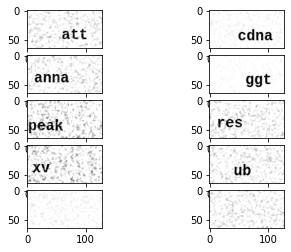

In [ ]:
import matplotlib.pyplot as plt

sample_batch = next(iter(trn_dataset))

f, axarr = plt.subplots(5, 2)
for i, ax in enumerate(f.axes):
    # Image is in (W, H, 1) format. Squeeze changes this to (W, H), and .T
    # transposes it to (H, W), allowing it to be displayed as grayscale image
    ax.imshow(np.squeeze(sample_batch[0][i]).T, cmap='gray', vmin=0, vmax=1)

## Preparing the model, optimizer, loss function, and metrics

### Model setup

For our model, we use a simplified CRNN with 2 bidirectional GRU layers. Notably, LSTMs can also be used in place of GRUs. 

In [ ]:
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
act = 'relu'
conv_to_rnn_dims = (IMG_W // (pool_size ** 2),
                    (IMG_H // (pool_size ** 2)) * conv_filters)

# Input layer
X = layers.Input(shape=(IMG_W, IMG_H, 1), dtype='float32')

# Convolution layers
inner = layers.Conv2D(conv_filters, kernel_size, padding='same',
                      activation=act, kernel_initializer='he_normal',
                      name='conv1')(X)
inner = layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = layers.Conv2D(conv_filters, kernel_size, padding='same',
                      activation=act, kernel_initializer='he_normal',
                      name='conv2')(inner)
inner = layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
inner = layers.Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
inner = layers.Dense(time_dense_size, activation=act, name='dense1')(inner)

# Recurrent layers: Two layers of bidirectional GRUs
gru_1 = layers.Bidirectional(layers.GRU(rnn_size, return_sequences=True,
                             kernel_initializer='he_normal'),
                             merge_mode='sum', name='bi_gru1')(inner)
gru_2 = layers.Bidirectional(layers.GRU(rnn_size, return_sequences=True,
                             kernel_initializer='he_normal'),
                             merge_mode='concat', name="bi_gru2")(gru_1)

# transforms RNN output to character activations:
inner = layers.Dense(len(ALPHABET)+1, kernel_initializer='he_normal',
                name='dense2')(gru_2)
y_pred = layers.Activation('softmax', name='softmax')(inner)

model = models.Model(inputs=X, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 64, 16)       160       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 64, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 32, 16)        2320      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 256)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 32)            8224  

### Optimizer

In [ ]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9,
                     nesterov=True, clipnorm=5)

### Loss function

To train our model, we make use of [CTC Loss](https://en.wikipedia.org/wiki/Connectionist_temporal_classification), or connectionist temporal classification. Keras's backend provides an implementation of the CTC Loss function that we can make use of. This backend implementation requires 4 inputs: 3 variables for the true label (`y_true`, `input_length`, and `label_length`) and 1 variable for `y_pred`. This poses an issue, because Keras loss functions must have the function signature `func(y, y_pred)` to be used in `model.compile()`. We can get around this, however, by concatenating the 3 label variables into a single Tensor within the dataset, then decomposing the label inside a custom loss function.  

Also within this loss function, we make one additional modification to `y_pred` to remove parts of the softmax output that aren't useful. 

In [ ]:
def ctc_loss(y, y_pred):
    # Decompose label into its subsequent parts
    input_length = y[:, 0:1]
    label_length = y[:, 1:2]
    y_true = y[:, 2:] 

    # From old example: "the first couple outputs of the RNN tend to be garbage"
    y_pred = y_pred[:, 2:, :]
    
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

### Evaluation metrics

A common way to compare the similarity between two strings is the [edit distance](https://en.wikipedia.org/wiki/Edit_distance) (often referred to as the Levenshtein distance). As well, Tensorflow provides an `edit_distance` function that we can use. Notably, however, this function requires that batches of input strings be in `SparseTensor` representation. So, we can't use the function as a Keras metric as-is.

Thankfully, there are a number of backend functions in Keras and Tensorflow that help us prepare our input. These functions are used internally by Keras to compute the CTC loss, but we can also repurpose them here. 

* `K.ctc_label_dense_to_sparse` converts our `y_true` input batch into `SparseTensor` form.
* `tf.nn.ctc_greedy_decoder` decodes the softmax output from the CRNN into a text string with the `SparseTensor` form. Note that this decoder is a special case of `tf.nn.ctc_beam_search_decoder`, which could be used for more complex (but time-consuming) decoding.

We combine these functions together into a custom Keras metric function. Like the custom CTC Loss we created before, custom metrics require the specific function signature `func(y, y_true)`. So, like before, we work with a concatenated label containing all 3 pieces of label information, which we then split into its subsequent parts.



In [ ]:
from IPython.core.debugger import set_trace

def edit_distance(y, y_pred):
    # Decompose label into its subsequent parts
    input_length = y[:, 0:1]
    label_length = y[:, 1:2]
    y_true = y[:, 2:]

    # This form is required by ctc_label_dense_to_sparse and ctc_greedy_decoder
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)

    # Get int64 SparseTensor representations of y_true and y_pred
    y_true_sparse = K.ctc_label_dense_to_sparse(y_true, label_length)
    y_true_sparse = tf.cast(y_true_sparse, tf.int64)

    y_pred = tf.transpose(y_pred, [1, 0, 2]) 
    decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(y_pred, input_length)
    y_pred_sparse = decoded[0]

    # Calculate Levenshtein distance for batch
    dist_batch = tf.edit_distance(y_pred_sparse, y_true_sparse)

    return tf.reduce_mean(dist_batch, axis=-1)

## Bringing it all together: the training routine

In [ ]:
model.compile(loss=ctc_loss, optimizer=sgd, metrics=[edit_distance])
model.fit(trn_dataset, batch_size=BATCH_SIZE, epochs=10, shuffle=True,
          validation_data=val_dataset)

Epoch 1/10
300/300 [==============================] - 438s 1s/step - loss: 10.9796 - edit_distance: 1.0004 - val_loss: 11.5623 - val_edit_distance: 1.0000
Epoch 2/10
300/300 [==============================] - 440s 1s/step - loss: 5.4310 - edit_distance: 0.6555 - val_loss: 2.3527 - val_edit_distance: 0.1777
Epoch 3/10
300/300 [==============================] - 428s 1s/step - loss: 9.3603 - edit_distance: 0.8518 - val_loss: 7.5752 - val_edit_distance: 0.6563
Epoch 4/10
300/300 [==============================] - 443s 1s/step - loss: 3.3730 - edit_distance: 0.4127 - val_loss: 2.3152 - val_edit_distance: 0.1827
Epoch 5/10
300/300 [==============================] - 432s 1s/step - loss: 1.6125 - edit_distance: 0.2675 - val_loss: 1.4227 - val_edit_distance: 0.1168
Epoch 6/10
300/300 [==============================] - 436s 1s/step - loss: 0.7229 - edit_distance: 0.1904 - val_loss: 0.9454 - val_edit_distance: 0.0851
Epoch 7/10
300/300 [==============================] - 453s 2s/step - loss: 0.890